<a href="https://colab.research.google.com/github/mkbensalah/Change-Detection-in-Hyperspectral-Images/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 5.3 MB/s eta 0:00:00


In [ ]:
# imports the drive module from the google.colab package and then mounts the Google Drive at /content/drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# imports various libraries and modules used for data processing, machine learning, and deep learning tasks.
import os
import random
import itertools
from random import shuffle
import h5py
import json
import tensorflow as tf

import numpy as np
import scipy
import scipy.io as sio # Scipy input and output
import scipy.ndimage
from skimage.transform import rotate
import spectral # Module for processing hyperspectral image data.
import matplotlib
%matplotlib inline

# scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

# keras imports
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, TimeDistributed
from keras.optimizers import SGD
from keras.models import load_model
from keras import backend as K
from keras.utils import np_utils

In [ ]:
#This function loads the specified dataset parameters from config.json, including the image paths and ground truth path, and returns the loaded data as a tuple.
def  load_dataset(dataset):
    """load dataset parameters from config.json"""


    with open('/content/drive/MyDrive/Minor Project/Config/config.json') as f:
        config = json.loads(f.read())
        params = config[dataset]
        data_1 = sio.loadmat(params['img_path_1'])['Data2009']
        data_2 = sio.loadmat(params['img_path_2'])['Data2015']
        labels = sio.loadmat(params['gt_path'])['GT_end']


    return data_1, data_2, labels

In [ ]:
#This line of code calls the load_dataset() function to load the Indian Pines dataset from the config.json file and returns the loaded data as three variables, data_1, data_2, and labels.
data_1, data_2 , labels= load_dataset("Indian_pines")



In [ ]:
#This function applies PCA to the input X data and returns a new transformed new_X data as well as the PCA object pca used for transforming the input data.
def apply_pca(X, num_components=75):
    """apply pca to X and return new_X"""

    new_X = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    new_X = pca.fit_transform(new_X)
    new_X = np.reshape(new_X, (X.shape[0],X.shape[1], num_components))
    return new_X, pca

In [ ]:
#This function applies zero padding to the input X data with the specified margin size and returns the new padded data new_X.
def pad_with_zeros(X, margin=2):
    """apply zero padding to X with margin"""

    new_X = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    new_X[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return new_X

In [ ]:
#Creates patches from an image with given window size and returns the patches data and patch labels.
def create_patches(X, y, window_size=7, remove_zero_labels = True):
    """create patch from image. suppose the image has the shape (w,h,c) then the patch shape is
    (w*h,window_size,window_size,c)"""

    margin = int((window_size - 1) / 2)
    zero_padded_X = pad_with_zeros(X, margin=margin)
    # split patches
    patches_data = np.zeros((X.shape[0] * X.shape[1], window_size, window_size, X.shape[2]))
    patchs_labels = np.zeros((X.shape[0] * X.shape[1]))
    patch_index = 0
    for r in range(margin, zero_padded_X.shape[0] - margin):
        for c in range(margin, zero_padded_X.shape[1] - margin):
            patch = zero_padded_X[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patches_data[patch_index, :, :, :] = patch
            patchs_labels[patch_index] = y[r-margin, c-margin] + 1
            patch_index = patch_index + 1

    if remove_zero_labels:
        patches_data = patches_data[patchs_labels>0,:,:,:]
        patchs_labels = patchs_labels[patchs_labels>0]
        patchs_labels -= 1
    return patches_data, patchs_labels

In [ ]:
#Split X and y into training and testing sets, where test_ratio specifies the proportion of samples that will be allocated to the test set.
def split_train_test_set(X, y, test_ratio=0.10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
from sklearn.model_selection import train_test_split

def split_train_validation_test_set(X, y, test_ratio=0.1, validation_ratio=0.1):
    """
    Split the data into training, validation, and test sets.

    Parameters:
        -- X: array-like, shape (n_samples, n_features)
            The feature data.
        -- y: array-like, shape (n_samples,)
            The target labels.
        -- test_ratio: float, optional (default=0.1)
            The proportion of samples to allocate to the test set.
        -- validation_ratio: float, optional (default=0.1)
            The proportion of samples to allocate to the validation set.

    Returns:
        -- X_train: array-like, shape (n_train_samples, n_features)
            The feature data for the training set.
        -- X_val: array-like, shape (n_val_samples, n_features)
            The feature data for the validation set.
        -- X_test: array-like, shape (n_test_samples, n_features)
            The feature data for the test set.
        -- y_train: array-like, shape (n_train_samples,)
            The target labels for the training set.
        -- y_val: array-like, shape (n_val_samples,)
            The target labels for the validation set.
        -- y_test: array-like, shape (n_test_samples,)
            The target labels for the test set.
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345,
                                                        stratify=y)

    # Split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_ratio,
                                                      random_state=345, stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
#Perform oversampling of weak classes to balance the dataset
def oversample_weak_classes(X, y):
    """"balance the dataset by prforming oversample of weak classes (making each class have close labels_counts)"""
    unique_labels, labels_counts = np.unique(y, return_counts=True)

    print(unique_labels.shape)
    print(unique_labels)
    print(labels_counts.shape)
    print(labels_counts)
    max_count = np.max(labels_counts)
    labels_inverse_ratios = max_count / labels_counts
    #print(labels_inverse_ratios)
    # repeat for every label and concat
    print(labels_inverse_ratios)
    new_X = X[y == unique_labels[0], :, :, :].repeat(round(labels_inverse_ratios[0]), axis=0)
    new_Y = y[y == unique_labels[0]].repeat(round(labels_inverse_ratios[0]), axis=0)
    for label, labelInverseRatio in zip(unique_labels[1:], labels_inverse_ratios[1:]):
        cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        new_X = np.concatenate((new_X, cX))
        new_Y = np.concatenate((new_Y, cY))
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(new_Y.shape[0])
    new_X = new_X[rand_perm, :, :, :]
    new_Y = new_Y[rand_perm]
    unique_labels, labels_counts = np.unique(new_Y, return_counts=True)

#     print(unique_labels.shape)
#     print(unique_labels)
#     print(labels_counts.shape)
#     print(labels_counts)
    return new_X, new_Y

In [ ]:
#Function to perform data augmentation on a 4D numpy array of image patches by randomly flipping or rotating each patch.
def augment_data(X_train):
    """augment the data by taking each patch and randomly performing
    a flip(up/down or right/left) or a rotation"""

    for i in range(int(X_train.shape[0]/2)):
        patch = X_train[i,:,:,:]
        num = random.randint(0,2)
        if (num == 0):

            flipped_patch = np.flipud(patch)
        if (num == 1):

            flipped_patch = np.fliplr(patch)
        if (num == 2):

            no = random.randrange(-180,180,30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                               reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)


        patch2 = flipped_patch
        X_train[i,:,:,:] = patch2

    return X_train

In [ ]:
#Parameters
dataset = "Indian_pines" # Indian_pines or PaviaU or or Salinas  . check config.json
window_size = 7
num_pca_components = 30
test_ratio = 0.25

In [ ]:
#This code loads and preprocesses the dataset, applies PCA, creates patches, splits the data into train and test sets, oversamples weak classes, and augments the data, and converts the class labels to one-hot encoding.
X_1, X_2, y = load_dataset(dataset)

X_1,pca = apply_pca(X_1,num_pca_components)
X_1_patches, y_patches = create_patches(X_1, y, window_size=window_size)
X_1_train, X_1_val, X_1_test, y_1_train, y_1_val, y_1_test = split_train_validation_test_set(X_1_patches, y_patches, test_ratio=0.1, validation_ratio=0.1)
#X_1_train, X_1_test, y_1_train, y_test = split_train_test_set(X_1_patches, y_patches, test_ratio)
X_1_train, y_1_train = oversample_weak_classes(X_1_train, y_1_train)
X_1_train = augment_data(X_1_train)

X_2,pca = apply_pca(X_2,num_pca_components)
X_2_patches, y_patches = create_patches(X_2, y, window_size=window_size)
X_2_train, X_2_val, X_2_test, y_2_train, y_2_val, y_2_test = split_train_validation_test_set(X_2_patches, y_patches, test_ratio=0.1, validation_ratio=0.1)
#X_2_train, X_2_test, y_train, y_test = split_train_test_set(X_2_patches, y_patches, test_ratio)
X_2_train, y_train = oversample_weak_classes(X_2_train, y_2_train)
X_2_train = augment_data(X_2_train)







y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_1_test)
y_train = y_train[:,-1]
print(X_1_train.shape)
print(X_1_train.ndim)
print(X_2_train.shape)
print(X_2_train.ndim)
print(y_test.shape)
print(y_1_train.shape)

(2,)
[0. 1.]
(2,)
[29618  2782]
[ 1.         10.64629763]


<ipython-input-22-2881f7300fc1>:18: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(2,)
[0. 1.]
(2,)
[29618  2782]
[ 1.         10.64629763]


<ipython-input-22-2881f7300fc1>:18: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(60220, 7, 7, 30)
4
(60220, 7, 7, 30)
4
(4000, 2)
(60220,)


In [ ]:
print(np.unique(y))

[0 1]


In [ ]:
#This code is combining and reshaping two sets of input data into a single 5D numpy array, and also creating a labels array.
data = np.zeros(shape=(60220,2,7,7,30))
labels = np.zeros(shape=(60220,1))
labels = y_train
data_1 = np.array([X_1_train[0], X_2_train[0]])
data[0] = data_1
for i in range(1, 60220):
  x = np.array([X_1_train[i], X_2_train[i]])

  data[i] = x
print(data.shape)
print(data.ndim)

print(y_train.shape)
print(y_train.ndim)


(60220, 2, 7, 7, 30)
5
(60220,)
1


In [ ]:
#This code is combining and reshaping two sets of input data into a single 5D numpy array, and also creating a labels array.
data_val = np.zeros(shape=(3600,2,7,7,30))
labels_val = np.zeros(shape=(3600,1))
labels_val = y_1_val
data_5 = np.array([X_1_val[0], X_2_val[0]])
data_val[0] = data_5
for i in range(1, 3600):
  x = np.array([X_1_val[i], X_2_val[i]])

  data_val[i] = x
print(data_val.shape)
print(data_val.ndim)


(3600, 2, 7, 7, 30)
5


In [ ]:
print(X_2_val.shape)

(3600, 7, 7, 30)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, GlobalAveragePooling3D, Dense, Add, TimeDistributed, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

def residual_block(input_tensor, filters, kernel_size=3):
    # Residual block consisting of two 2D convolutional layers and an element-wise addition operation
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def define_model(num_pca_components=10):
    # Define input shape
    input_shape = (2, 7, 7, 30) # (batch_size, sequence_length, height, width, channels)
    C1 = 3 * num_pca_components # Number of filters in the first convolutional layer

    # Define input tensor
    input_tensor = Input(shape=input_shape)

    # Encoder
    # Apply two convolutional layers with C1 filters, followed by a residual block and max pooling
    x1 = TimeDistributed(Conv2D(C1, (3, 3), padding='same', activation='relu'))(input_tensor)
    x1 = TimeDistributed(Conv2D(C1, (3, 3), padding='same', activation=None))(x1)
    shortcut1 = x1
    x2 = residual_block(x1, C1)
    x2 = residual_block(x2, C1)
    x2 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x2)

    # Apply two convolutional layers with 2*C1 filters, followed by a residual block, shortcut connection, and max pooling
    x3 = TimeDistributed(Conv2D(2 * C1, (3, 3), padding='same', activation='relu'))(x2)
    x3 = TimeDistributed(Conv2D(2 * C1, (3, 3), padding='same', activation=None))(x3)
    shortcut2 = x3
    x4 = residual_block(x3, 2 * C1)
    x4 = residual_block(x4, 2 * C1)
    x4 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x4)

    # Apply two convolutional layers with 4*C1 filters, followed by a residual block, shortcut connection, and max pooling
    x5 = TimeDistributed(Conv2D(4 * C1, (3, 3), padding='same', activation='relu'))(x4)
    x5 = TimeDistributed(Conv2D(4 * C1, (3, 3), padding='same', activation=None))(x5)
    shortcut3 = x5
    x6 = residual_block(x5, 4 * C1)
    x6 = residual_block(x6, 4 * C1)
    x6 = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x6)

    # Flatten output and pass through LSTM layer
    x7 = TimeDistributed(Flatten())(x6)
    x7 = LSTM(128)(x7)

    # Fully connected layers
    x8 = Dense(1024, activation='relu')(x7)
    x8 = Dense(512, activation='relu')(x8)
    out = Dense(1, activation='sigmoid')(x8)

    # Define the model input, output, and compile the model
    model = Model(inputs=input_tensor, outputs=out)

    # Use a smaller learning rate for better convergence
    adam = Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss=binary_crossentropy, metrics=['accuracy'])
    return model



In [ ]:
print(num_pca_components)
model = define_model()
model.summary()

30
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 7, 7, 30  0           []                               
                                )]                                                                
                                                                                                  
 time_distributed (TimeDistribu  (None, 2, 7, 7, 30)  8130       ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 2, 7, 7, 30)  8130       ['time_distributed[0][0]']       
 buted)                                                                                    

In [ ]:
model.fit(data, labels,validation_data=(data_val, labels_val), batch_size=32, epochs=5)

Epoch 1/5
1882/1882 [==============================] - 314s 163ms/step - loss: 0.1136 - accuracy: 0.9606 - val_loss: 0.0766 - val_accuracy: 0.9681
Epoch 2/5
1882/1882 [==============================] - 295s 157ms/step - loss: 0.0616 - accuracy: 0.9796 - val_loss: 0.0374 - val_accuracy: 0.9867
Epoch 3/5
1882/1882 [==============================] - 295s 157ms/step - loss: 0.0487 - accuracy: 0.9842 - val_loss: 0.0534 - val_accuracy: 0.9803
Epoch 4/5
1882/1882 [==============================] - 296s 158ms/step - loss: 0.0409 - accuracy: 0.9868 - val_loss: 0.0393 - val_accuracy: 0.9861
Epoch 5/5
1882/1882 [==============================] - 294s 156ms/step - loss: 0.0342 - accuracy: 0.9886 - val_loss: 0.0661 - val_accuracy: 0.9828


In [ ]:
model.save('/content/drive/MyDrive/Minor Project/Std_Unet.h5')

In [ ]:
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Minor Project/Std_Unet.h5'
model = load_model(model_path)


In [ ]:
# We have already trained the model (for testing)
data_1 = np.array([X_1_train[4], X_1_train[5]])

data_2= np.array([X_1_train[6], X_1_train[7]])

data = np.array([data_1, data_2])
X = data
print(data.shape)
print(data.ndim)
labels =np.array([y_train[0], y_train[1]])
print(labels.shape)
print(labels.ndim)
print(y.shape)
patch_size = window_size
height = y.shape[0]
width = y.shape[1]

(2, 2, 7, 7, 30)
5
(2,)
1
(200, 200)


In [ ]:
X_1, X_2,y = load_dataset("Indian_pines")
X_1,pca = apply_pca(X_1,num_pca_components)
X_2,pca = apply_pca(X_2,num_pca_components)
height = y.shape[0]
width = y.shape[1]
patch_size = window_size
data = np.zeros(shape=(100,2,7,7,30))
data_1 = np.array([X_1, X_2])
X = X_1
print(X_1.shape)

print(x.ndim)


(200, 200, 30)
4


In [ ]:
num_patches = (height - patch_size + 1) * (width - patch_size + 1)
print(num_patches)

37636


In [ ]:
def get_patch(data,height_index,width_index):
    #transpose_array = data.transpose((2,0,1))
    #print transpose_array.shape
    height_slice = slice(height_index, height_index+patch_size)
    width_slice = slice(width_index, width_index+patch_size)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
def generate_pridected_image():
    """generate the predicted image"""
    outputs = np.zeros((height,width))

    for i in range(height-patch_size+1):
        for j in range(width-patch_size+1):
            target = y[int(i+patch_size/2), int(j+patch_size/2)]
            if target == 0 :
                continue
            else :
                image_patch=get_patch(X,i,j)
                X_test_image = image_patch.reshape(7,7,30).astype('float32')
                image_patch=get_patch(X_2,i,j)
                X_2_test_image = image_patch.reshape(7,7,30).astype('float32')

                X_F = np.array([X_test_image, X_2_test_image])
                X_2_F = X_F.reshape(1,X_F.shape[0],X_F.shape[1],X_F.shape[2],X_F.shape[3])

                prediction = ((model.predict(X_2_F) > 0.9).astype("int32"))
                outputs[int(i+patch_size/2)][int(j+patch_size/2)] = prediction+1
    return outputs.astype(int)

In [ ]:
outputs=generate_pridected_image()


1/1 [==============================] - 0s 38ms/step


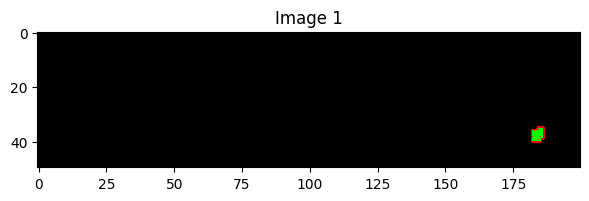

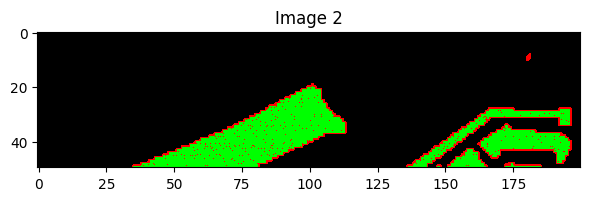

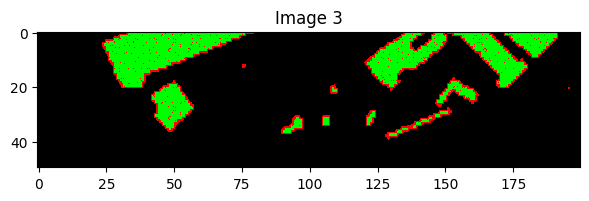

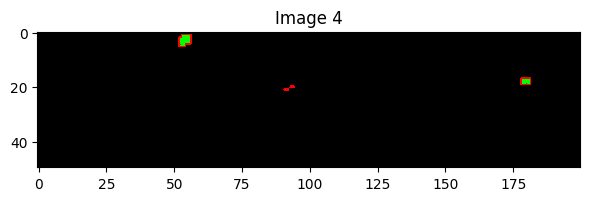

In [ ]:
import numpy as np
import spectral
import matplotlib.pyplot as plt


num_splits = 4
split_outputs = np.array_split(outputs, num_splits)

for i, split_output in enumerate(split_outputs):
    spectral.imshow(classes=split_output.astype(int), figsize=(7,7))
    plt.title(f"Image {i+1}")

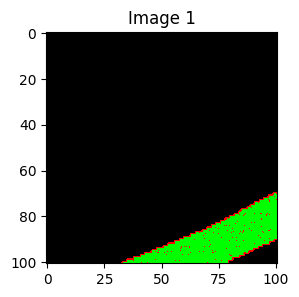

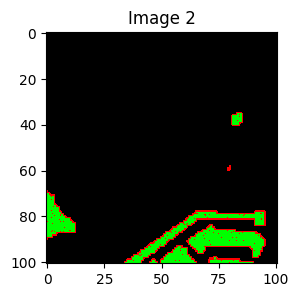

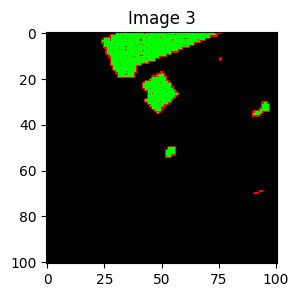

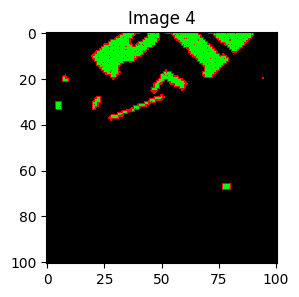

In [ ]:
import numpy as np
import spectral


num_splits = 8
split_size = int(np.sqrt(num_splits))

# calculate padding size
pad_size0 = split_size - (outputs.shape[0] % split_size)
pad_size1 = split_size - (outputs.shape[1] % split_size)
padded_outputs = np.pad(outputs, ((0, pad_size0), (0, pad_size1)), mode='constant')

# split padded_outputs
split_outputs = np.split(padded_outputs, split_size)

images = []
for split_output in split_outputs:
    images.extend(np.split(split_output, split_size, axis=1))

for i, image in enumerate(images):
    spectral.imshow(classes=image.astype(int), figsize=(3,3))
    plt.title(f"Image {i+1}")

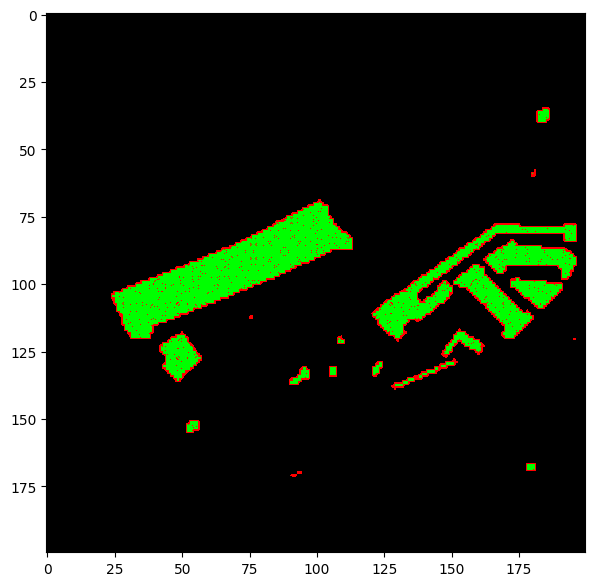

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

/usr/local/lib/python3.9/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


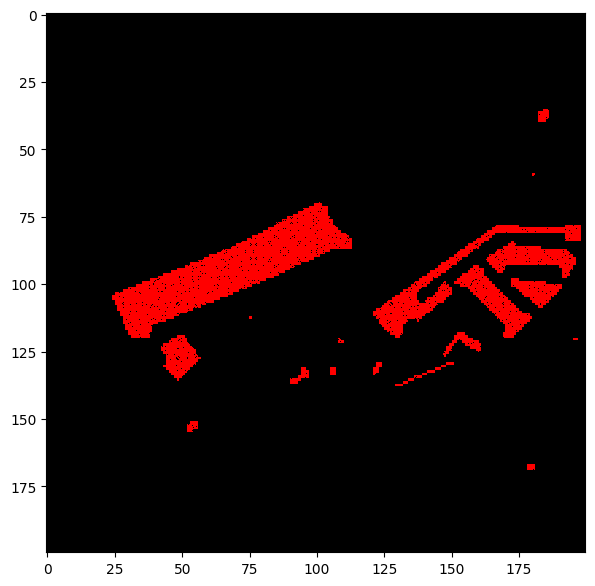

In [ ]:
gt_image = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
#Model evaluation
loss, accuracy = evaluate_model(model, data2, y_2_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


Test set loss: 0.0395
Test set accuracy: 0.9861
Test loss: 0.03945516049861908
Test accuracy: 0.9861000180244446


In [ ]:
X_1, X_2, y = load_dataset(dataset)

X_1,pca = apply_pca(X_1,num_pca_components)
X_1_patches, y_patches = create_patches(X_1, y, window_size=window_size)
X_1_train, X_1_test, y_1_train, y_1_test = split_train_test_set(X_1_patches, y_patches, test_ratio)
X_1_train, y_1_train = oversample_weak_classes(X_1_train, y_1_train)
X_1_train = augment_data(X_1_train)

X_2,pca = apply_pca(X_2,num_pca_components)
X_2_patches, y_patches = create_patches(X_2, y, window_size=window_size)
X_2_train, X_2_test, y_train, y_2_test = split_train_test_set(X_2_patches, y_patches, test_ratio)
X_2_train, y_train = oversample_weak_classes(X_2_train, y_train)
X_2_train = augment_data(X_2_train)







y_train = np_utils.to_categorical(y_train) # convert class labels to on-hot encoding
y_2_test = np_utils.to_categorical(y_2_test)
y_train = y_train[:,-1]
y_2_test = y_2_test[:,-1]
print(X_1_train.shape)
print(X_1_train.ndim)
print(X_2_train.shape)
print(X_2_train.ndim)
print(y_1_test.shape)
print(y_1_train.shape)

(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]


<ipython-input-11-966bd6f111d9>:17: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(2,)
[0. 1.]
(2,)
[27424  2576]
[ 1.         10.64596273]


<ipython-input-11-966bd6f111d9>:17: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),


(55760, 7, 7, 30)
4
(55760, 7, 7, 30)
4
(10000,)
(55760,)


In [ ]:
print(X_2_test.shape)

(10000, 7, 7, 30)


In [ ]:
data2 = np.zeros(shape=(10000,2,7,7,30))
labels = np.zeros(shape=(10000,1))
labels2 = np.array([y_1_test[0], y_2_test[0]])
data_12 = np.array([X_1_test[0], X_2_test[0]])
data2[0] = data_12
for i in range(1, 10000):
  x = np.array([X_1_test[i], X_2_test[i]])

  data2[i] = x


print(data2.shape)
print(X_2_test.shape)



(10000, 2, 7, 7, 30)
(10000, 7, 7, 30)


In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set"""
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test set loss: {:.4f}".format(loss))
    print("Test set accuracy: {:.4f}".format(accuracy))
    return loss, accuracy


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score


# Obtain the predicted labels for the validation data
y_pred = model.predict(data_val)
y_pred = (y_pred > 0.5).astype(int)


# Calculate Precision
precision = precision_score(labels_val, y_pred)


# Calculate Recall
recall = recall_score(labels_val, y_pred)


# Calculate F1 Score
f1_score = f1_score(labels_val, y_pred)


# Calculate Cohen's Kappa
kappa = cohen_kappa_score(labels_val, y_pred)


print(f"Precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")
print(f"kappa: {kappa}")

113/113 [==============================] - 5s 40ms/step
Precision: 0.8472222222222222
recall: 0.9870550161812298
f1_score: 0.9118086696562033
kappa: 0.902832674571805
